
---


# **CS 4824/ECE 4424, Final Project**
##**Leonardo Apollaro Gama**
---



In [36]:
# libraries
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

### **Loading Dataset**
The default file path assumes that data set is on the same folder as the python project and save under the file `fer2013`.

In [37]:
#Append the directory to your python path using sys
import sys
import os

# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'fer2013/'
sys_path = customized_path_to_your_homework
sys.path.append(sys_path)
# print(sys.path)

fp_train = os.path.join(sys_path, 'train/')
fp_test = os.path.join(sys_path, 'test/')
print('Path to train: {}'.format(fp_train))
print('Path to test: {}'.format(fp_test))

Path to train: fer2013/train/
Path to test: fer2013/test/


# **Visualize and Explore the dataset**
To better understand the dataset, we can check the number of emotions categories and the nomber of images in each category.

In [38]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(fp_train, 'train')
test_count = count_exp(fp_test, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<AxesSubplot:>

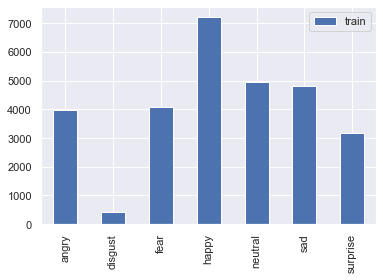

In [39]:
train_count.transpose().plot(kind='bar')

<AxesSubplot:>

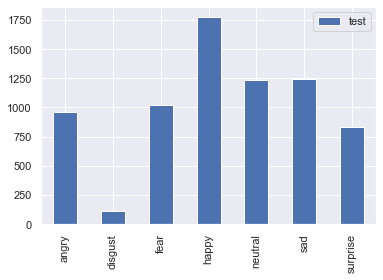

In [40]:
test_count.transpose().plot(kind='bar')

Now lets visualize some of the avalable images for each emotion category

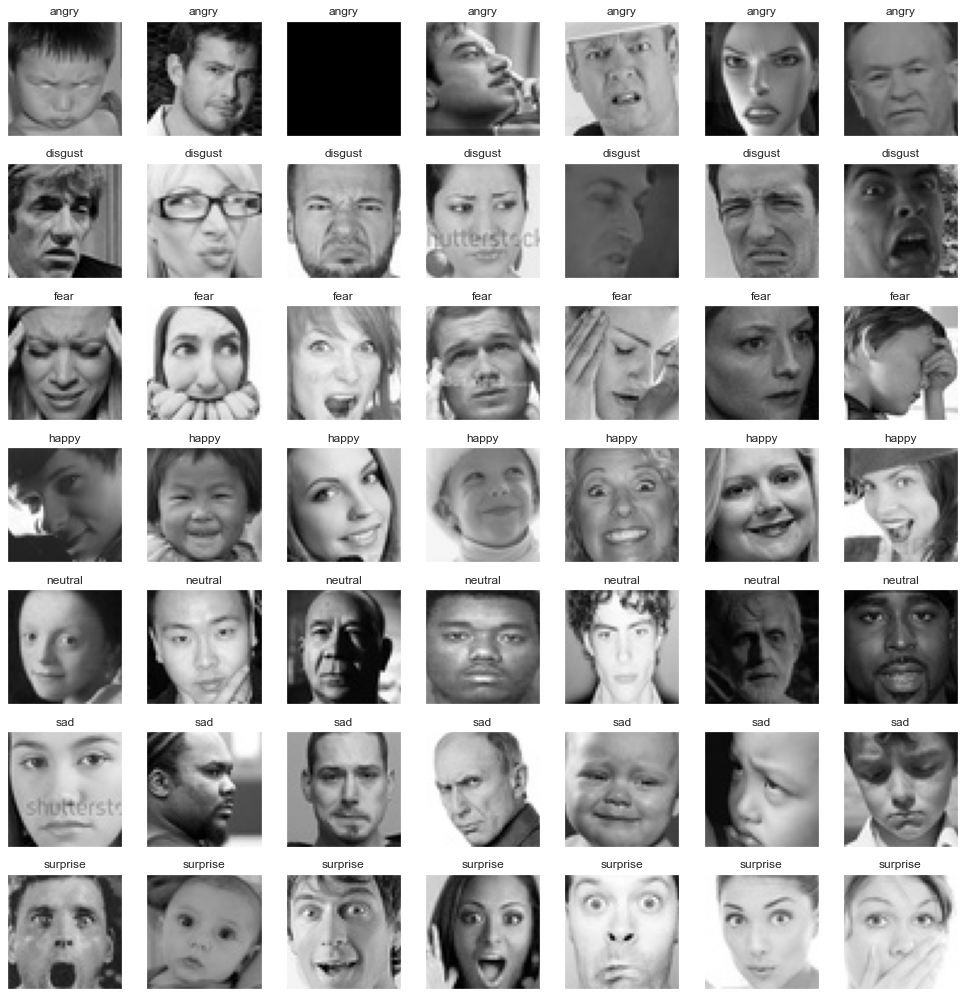

In [41]:
fig = plt.figure(1, (14, 14))

k = 0
for expression in os.listdir(fp_train):
  for j in range(7):
    img = load_img((fp_train + expression +'/'+ os.listdir(fp_train + expression)[k]))
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(expression)
    plt.tight_layout()

# **Base CNN model Architecture**

First lest try a simple CNN with relu activation and Adam Optimizer
also using a common pattern: a stack of Conv2D, MaxPooling2D and dropout layers.

In [42]:
def build_model():
    num_classes = 7
    
    model = Sequential()
    
    model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     input_shape=(48,48,1),
                     activation='relu',
                     padding='same'))
    model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128,
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))    
    model.add(Dropout(0.5))

    model.add(Dense(num_classes,
                    activation='softmax',
                    name='out_layer'))

    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    model.summary()

    return model

# **Create train test and validation datasets**
Using `ImageDataGenarator` to help with model perfromance such that it will add changes to the images that are often encountered in real world like shearing, rotations etc. In addition also normalizes the data.

In addition lets set the batch_size.

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True)

batch_size = 64

training_set = train_datagen.flow_from_directory(fp_train,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

testing_set = train_datagen.flow_from_directory(fp_test,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [44]:
# labels
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# **Model Training**

Before training lets visualize the model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                 

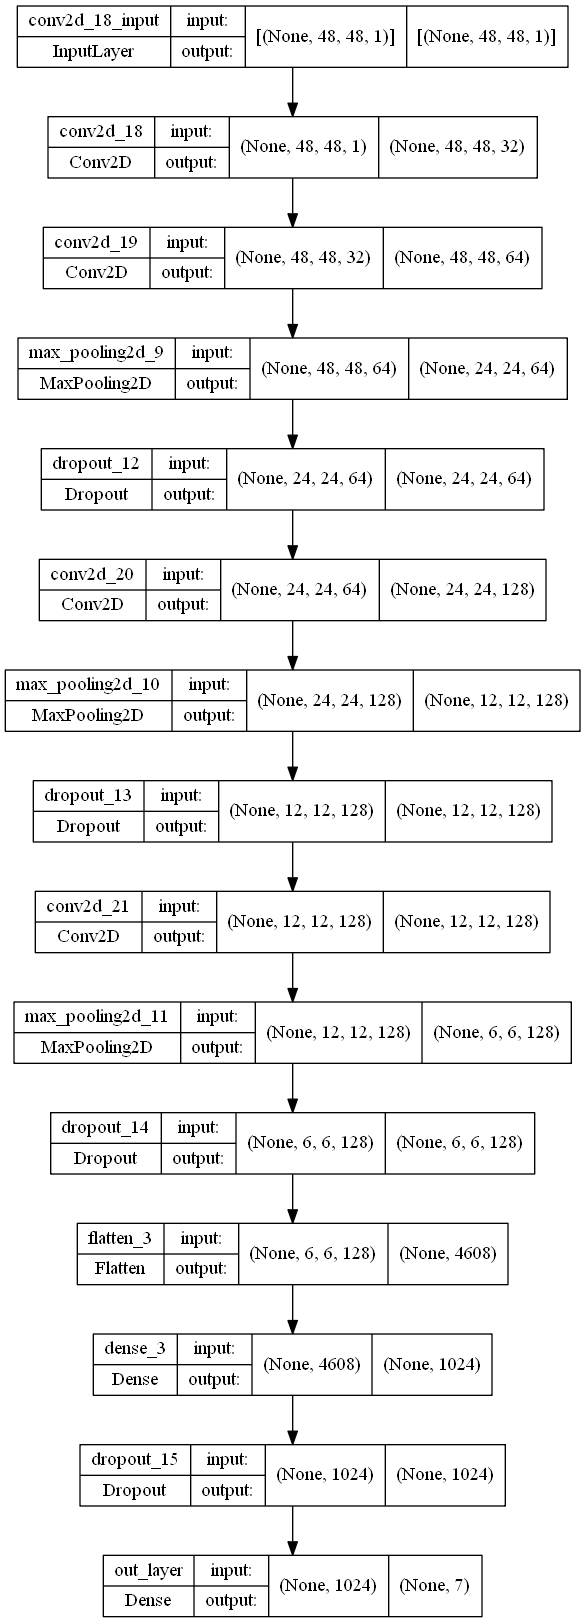

In [45]:
model = build_model()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Training

In [46]:
epochs = 50
steps_per_epoch = training_set.n // training_set.batch_size

history = model.fit(training_set,
                    validation_data=testing_set,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/50
448/448 [==============================] - 18s 40ms/step - loss: 1.7975 - accuracy: 0.2511 - val_loss: 1.7719 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 17s 37ms/step - loss: 1.7512 - accuracy: 0.2802 - val_loss: 1.7081 - val_accuracy: 0.2885 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 17s 37ms/step - loss: 1.6952 - accuracy: 0.3158 - val_loss: 1.6198 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 17s 38ms/step - loss: 1.6014 - accuracy: 0.3676 - val_loss: 1.4919 - val_accuracy: 0.4199 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 17s 37ms/step - loss: 1.5075 - accuracy: 0.4115 - val_loss: 1.4043 - val_accuracy: 0.4563 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 17s 37ms/step - loss: 1.4428 - accuracy: 0.4404 - val_loss: 1.3765 - val_accuracy: 0.4656 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 17s 

Lets save the model and model weights for later use

In [47]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
model.save_weights("model_weights.h5")

# **Results Plot and Analysis**

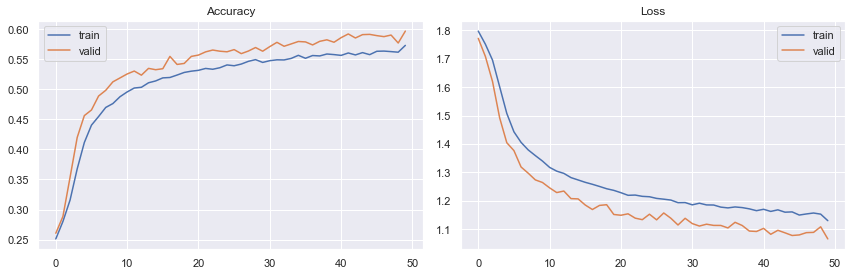

In [48]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_cnn.png')
plt.show()

Plot the distribution of training and validation metrics

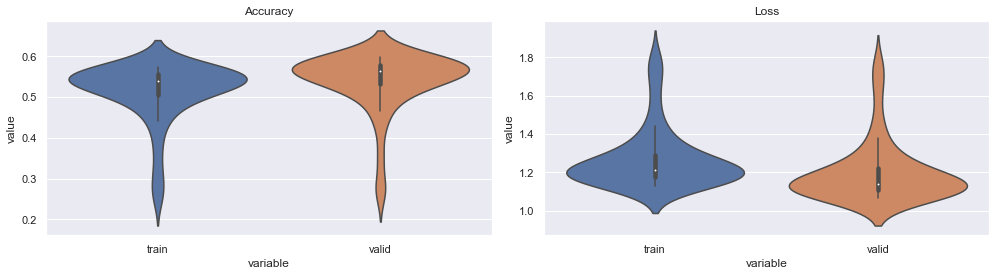

In [49]:
d_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
d_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(d_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(d_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist.png')
plt.show()

Lets also plot the confusion-matrix to better understand the model performance

Confusion Matrix
[[ 496   17  286 1057  695 1012  432]
 [  66    2   27  119   81   95   46]
 [ 461    9  286 1151  747 1005  438]
 [ 800   20  469 2063 1257 1783  823]
 [ 579   22  354 1365  894 1206  545]
 [ 613   16  324 1289  883 1210  495]
 [ 351    6  238  900  556  760  360]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.12      0.13      3995
     disgust       0.02      0.00      0.01       436
        fear       0.14      0.07      0.09      4097
       happy       0.26      0.29      0.27      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.25      0.20      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.15      0.14     28709
weighted avg       0.18      0.18      0.18     28709



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

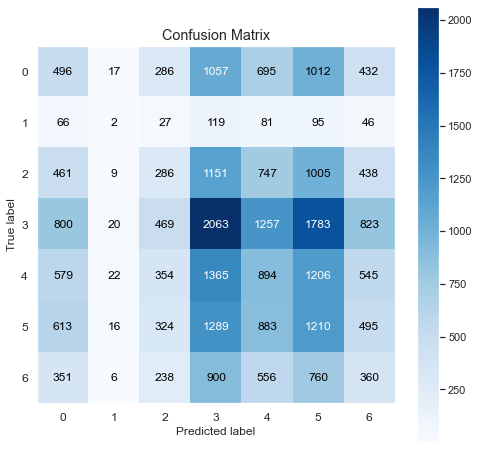

In [54]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

scikitplot.metrics.plot_confusion_matrix(training_set.classes, y_pred, figsize=(8, 8))

'angry': 0
'disgust': 1
'fear': 2
'happy': 3
'neutral': 4
'sad': 5
'surprise': 6

# **Improved CNN model Architecture**

For generalization purpose dropouts are used at regular intervals.

ELU is used as the activation function on an attempt to avoid dying relu problem..

he_normal is used as kernel initializer as it suits ELU.

Batch Normalization is also used for better results.

In [53]:
def build_model_2():
    num_classes = 7

    model = Sequential()

    model.add(Conv2D(filters=64,
                 kernel_size=(5,5),
                 input_shape=(48,48,1),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,
                   kernel_size=(5,5),
                   activation='elu',
                   padding='same',
                   kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=128,
                   kernel_size=(3,3),
                   activation='elu',
                   padding='same',
                   kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,
                   kernel_size=(3,3),
                   activation='elu',
                   padding='same',
                   kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=256,
                   kernel_size=(3,3),
                   activation='elu',
                   padding='same',
                   kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,
                   kernel_size=(3,3),
                   activation='elu',
                   padding='same',
                   kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128,
                  activation='elu',
                  kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Dropout(0.6))

    model.add(Dense(num_classes,
                  activation='softmax',
                  name='out_layer'))

    opt = keras.optimizers.Adam(0.001)

    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    model.summary()

    return model

We can use callbacks like `early stopping` for avoiding over-fitting the training data, and `ReduceLROnPlateau` for reducing learning rate whenever the validation accuracy plateaus.

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.00005,
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                 factor=0.5,
                                 patience=7,
                                 min_lr=1e-7,
                                 verbose=1)

callbacks = [early_stopping, lr_scheduler]

Create train test and validation datasets, then train and plot result for the second model
This time also lests try it a smaller batch size = 32 and increase epochs since now we have early-stopping

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                              

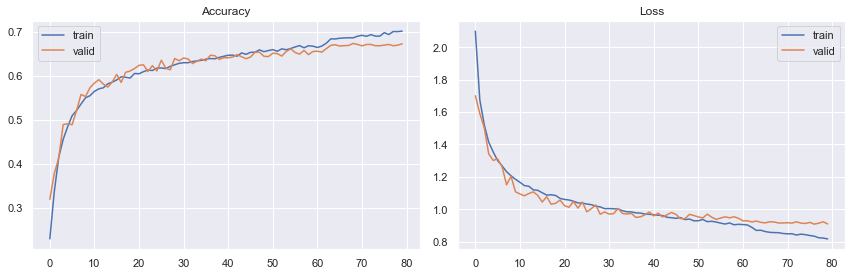

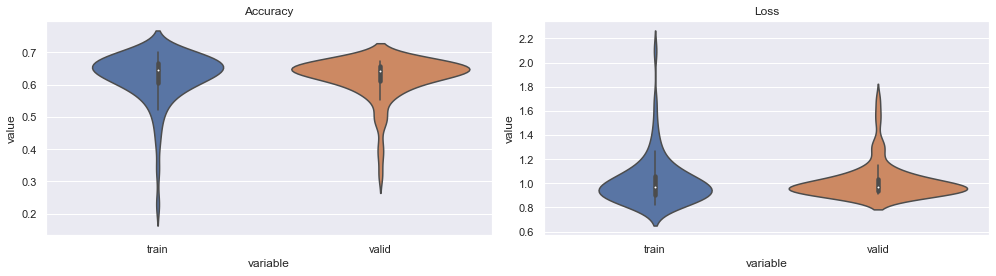

Confusion Matrix
[[ 520   42  394 1054  812  700  473]
 [  62    7   49  119   90   61   48]
 [ 586   51  423 1037  830  672  498]
 [1015   78  719 1878 1446 1203  876]
 [ 672   52  482 1309 1003  844  603]
 [ 669   63  557 1224  988  794  535]
 [ 431   30  332  786  665  548  379]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.10      0.12      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.20      0.19      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.11      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

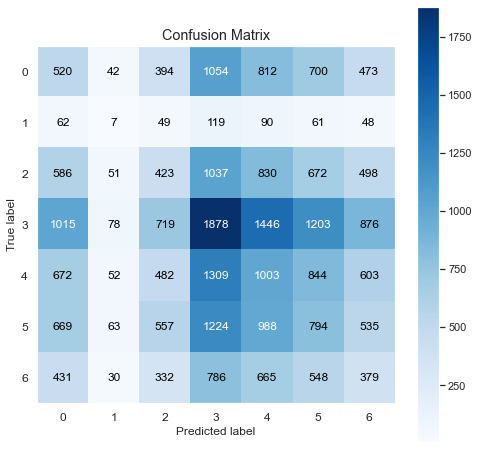

In [55]:
batch_size = 32
epochs = 200

training_set = train_datagen.flow_from_directory(fp_train,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

testing_set = train_datagen.flow_from_directory(fp_test,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

model = build_model_2()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

steps_per_epoch = training_set.n // training_set.batch_size

history = model.fit(training_set,
                    validation_data=testing_set,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

model_json = model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model_2.h5")
model.save_weights("model_2_weights.h5")

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_cnn_2.png')
plt.show()

d_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
d_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(d_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(d_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist_2.png')
plt.show()

y_pred = model_2.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

scikitplot.metrics.plot_confusion_matrix(training_set.classes, y_pred, figsize=(8, 8))

# **Lets try same model but with different batch size = 64**

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_35 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_36 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                              

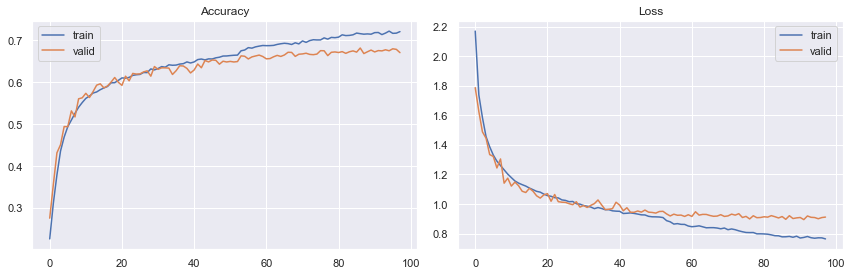

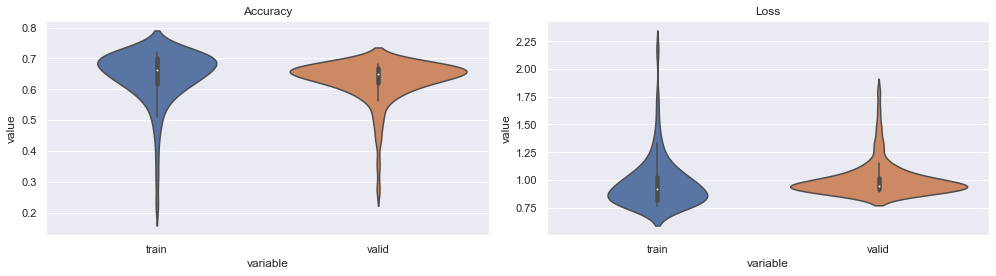

Confusion Matrix
[[ 545   55  420 1019  795  665  496]
 [  64    8   53  111   82   66   52]
 [ 553   53  407 1078  834  692  480]
 [ 969   91  776 1839 1482 1218  840]
 [ 675   53  517 1269  976  892  583]
 [ 692   50  532 1228  953  782  593]
 [ 430   31  306  827  641  568  368]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.10      0.11      4097
       happy       0.25      0.25      0.25      7215
     neutral       0.17      0.20      0.18      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.11      0.12      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

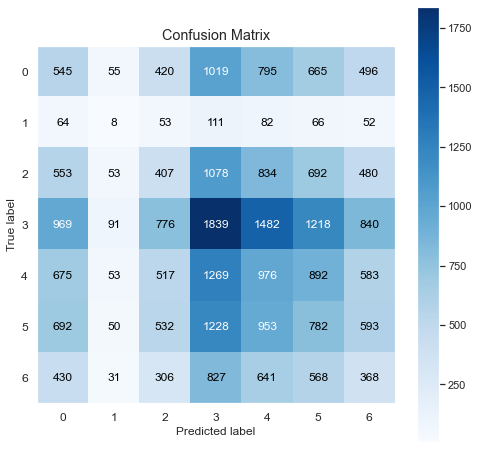

In [57]:
batch_size = 64
epochs = 200

training_set = train_datagen.flow_from_directory(fp_train,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

testing_set = train_datagen.flow_from_directory(fp_test,
                                                batch_size=batch_size,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

model = build_model_2()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

steps_per_epoch = training_set.n // training_set.batch_size

history = model.fit(training_set,
                    validation_data=testing_set,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

model_json = model.to_json()
with open("model_3.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model_3.h5")
model.save_weights("model_3_weights.h5")

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_cnn_3.png')
plt.show()

d_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
d_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(d_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(d_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist_3.png')
plt.show()

y_pred = model_2.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

scikitplot.metrics.plot_confusion_matrix(training_set.classes, y_pred, figsize=(8, 8))

'angry': 0
'disgust': 1
'fear': 2
'happy': 3
'neutral': 4
'sad': 5
'surprise': 6

# **Plotting Predictions**

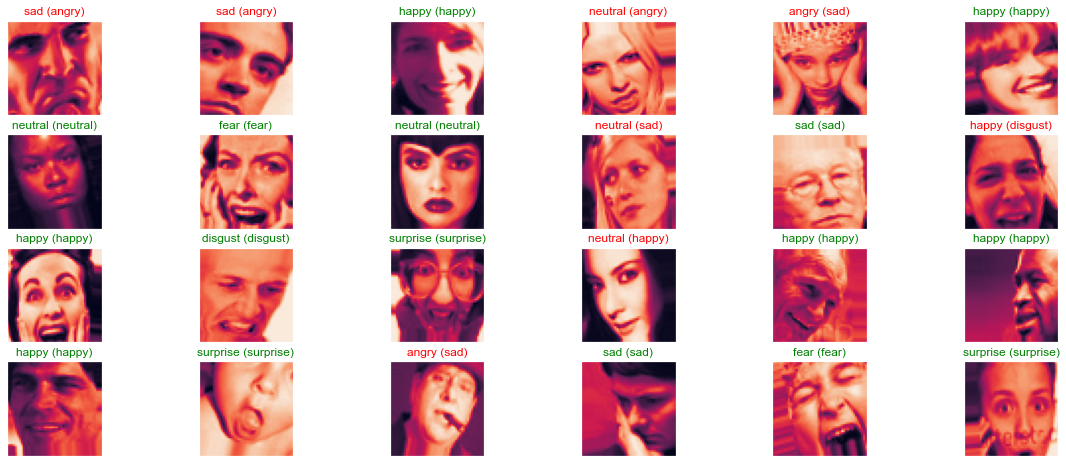

In [60]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test, y_test = next(testing_set)
predict = model.predict(x_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))